# Comparative Attention Metrics: GPT-2 Prototype vs. T5-Small

This notebook computes five interpretability metrics—**Entropy**, **Volatility**, **Focus Span**, **Head Agreement**, and **SAAS**—on 20 QA pairs  
(10 Medical, 10 Legal), using **two** transformer pipelines:

1. **GPT-2** (decoder-only self-attention)  
2. **T5-small** (encoder self-attention, decoder self-attention, cross-attention)



In [1]:
# ─── Section 1: Imports & Setup ────────────────────────────────────────

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from transformers import (
    GPT2Tokenizer, GPT2LMHeadModel,
    T5Tokenizer, T5ForConditionalGeneration
)

%matplotlib inline
sns.set(style="whitegrid")


2025-07-08 17:11:24.104077: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# ─── Section 2: Define QA Pairs (10 Medical + 10 Legal) ───────────────

medical_questions = [
    "What is the first-line treatment for hypertension?",
    "Which antibiotic is used to treat streptococcal pharyngitis?",
    "What are the symptoms of diabetes mellitus?",
    "What condition is characterized by chronic airway inflammation?",
    "What is the normal range for adult blood pressure?",
    "How is a myocardial infarction diagnosed?",
    "What is the function of insulin in the body?",
    "What imaging is used for a suspected stroke?",
    "Which vaccine is recommended for HPV prevention?",
    "What causes peptic ulcer disease?"
]

legal_questions = [
    "What is the role of a plaintiff in a civil case?",
    "What does the term 'due process' refer to?",
    "What is double jeopardy in criminal law?",
    "What constitutes a breach of contract?",
    "What is the standard of proof in civil cases?",
    "What are Miranda rights?",
    "What is hearsay evidence?",
    "What is a tort?",
    "What is the function of appellate courts?",
    "What is legal precedent?"
]

qa_pairs = pd.DataFrame(
    [(q, 'Medical') for q in medical_questions] +
    [(q, 'Legal')  for q in legal_questions],
    columns=['Question', 'Domain']
)

qa_pairs


,Question,Domain
0,What is the first-line treatment for hypertens...,Medical
1,Which antibiotic is used to treat streptococca...,Medical
2,What are the symptoms of diabetes mellitus?,Medical
3,What condition is characterized by chronic air...,Medical
4,What is the normal range for adult blood press...,Medical
5,How is a myocardial infarction diagnosed?,Medical
6,What is the function of insulin in the body?,Medical
7,What imaging is used for a suspected stroke?,Medical
8,Which vaccine is recommended for HPV prevention?,Medical
9,What causes peptic ulcer disease?,Medical


In [53]:
# ─── Section 2.1: Data Sourcing & Sampling ────────────────────────────
#  `pip install datasets`
# don't run it now check this later. use the hardcoded Section 2 for now


from datasets import load_dataset

N = 40

# 1) Medical QA (medmcqa train split)
try:
    med_full = load_dataset("medmcqa", split="train")
    med_sample = med_full.shuffle(seed=42).select(range(min(N, len(med_full))))
except Exception as e:
    print("Warning loading medmcqa:", e)
    med_sample = [{"question": q} for q in qa_pairs.query("Domain=='Medical'").Question.tolist()][:N]

# 2) Legal QA: try COLIEE, else fallback to filtered SQuAD
legal_sample = None
try:
    legal_full = load_dataset("dzunggg/legal-qa-v1", split="train")
    legal_sample = legal_full.shuffle(seed=42).select(range(min(N, len(legal_full))))
except Exception as e:
    print("Warning loading legal-qa-v1:", e)
    legal_sample = [{"question": q} for q in qa_pairs.query("Domain=='Legal'").Question.tolist()][:N]


# 3) Build the DataFrame
new_pairs = []
for row in med_sample:
    new_pairs.append((row["question"], "Medical"))
for row in legal_sample:
    new_pairs.append((row["question"], "Legal"))

qa_pairs = pd.DataFrame(new_pairs, columns=["Question","Domain"])
print(f"Sampled {len(qa_pairs[qa_pairs.Domain=='Medical'])} medical and "
      f"{len(qa_pairs[qa_pairs.Domain=='Legal'])} legal pairs.")



Sampled 40 medical and 40 legal pairs.


In [59]:
# ─── Section 3: Metric Function Definitions ────────────────────────────

def compute_entropy(weights):
    """Entropy of a probability distribution (higher = more diffuse)."""
    return -np.sum(weights * np.log(weights + 1e-9))

def compute_volatility(attn_layers):
    """
    Variance of the argmax token index across layers.
    High volatility → focus jumps around.
    """
    top_idxs = [np.argmax(layer) for layer in attn_layers]
    return float(np.var(top_idxs))

def compute_span(attn_vector, threshold_ratio=0.1):
    """
    Range between tokens with attention ≥ threshold_ratio * max_attention.
    """
    thresh = threshold_ratio * np.max(attn_vector)
    idxs = np.where(attn_vector >= thresh)[0]
    return int(idxs.max() - idxs.min()) if len(idxs) > 1 else 0

def compute_head_agreement(head_attn):
    """
    Fraction of heads that agree on the same top-attended token.
    head_attn: array of shape (num_heads, seq_len)
    """
    top_idxs = [np.argmax(h) for h in head_attn]
    most_common = max(set(top_idxs), key=top_idxs.count)
    return float(top_idxs.count(most_common) / len(top_idxs))

# Keywords for SAAS
keywords = {
    'Medical': ['treatment','hypertension','symptoms','diagnosed','insulin','vaccine','infection'],
    'Legal':  ['plaintiff','contract','due','jeopardy','proof','rights','tort','precedent']
}


In [55]:
# ─── Section 4: GPT-2 Prototype Pipeline ───────────────────────────────

# Load GPT-2
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model     = GPT2LMHeadModel.from_pretrained("gpt2", output_attentions=True)
gpt2_model.eval()

def run_gpt2(question):
    """Return token list and self-attn tensors for GPT-2."""
    inputs = gpt2_tokenizer(question, return_tensors="pt")
    with torch.no_grad():
        out = gpt2_model(**inputs)
    return gpt2_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]), out.attentions

# Compute metrics for GPT-2
gpt2_results = []
for _, row in qa_pairs.iterrows():
    q, domain = row.Question, row.Domain
    tokens, atts = run_gpt2(q)
    last_idx = len(tokens) - 1
    # Average over heads for the last query token in each layer
    layers_avg = np.stack([
        att[0].mean(axis=0)[last_idx].cpu().numpy()
        for att in atts
    ])  # shape (num_layers, seq_len)

    entropy    = np.mean([compute_entropy(l) for l in layers_avg])
    volatility = compute_volatility(layers_avg)
    span       = compute_span(layers_avg[-1])
    head_agree = compute_head_agreement(atts[-1][0,:, last_idx].cpu().numpy())

    # SAAS: sum attention on keywords
    #kw_idxs = [i for i, t in enumerate(tokens)
    #           if t.lower().strip("Ġ?.,") in keywords[domain]]
    #saas = float(np.sum(layers_avg[-1][kw_idxs])) if kw_idxs else np.nan

    # 1) Build a numpy array of shape (layers, seq, seq)
    self_attn = np.stack([
        att[0].mean(axis=0).cpu().numpy()   # head-avg self-attn matrix
        for att in atts
    ])  # → (layers, seq, seq)

    # 2) Average over query positions -> (layers, seq)
    avg_over_queries = self_attn.mean(axis=1)

    # 3) Average over layers -> (seq,)
    avg_across_layers = avg_over_queries.mean(axis=0)

    # 4) Identify keyword positions (strip the 'Ġ' prefix)
    clean_tokens = [t.lstrip("Ġ").lower() for t in tokens]
    kw_idxs = [i for i,t in enumerate(clean_tokens) if t in keywords[domain]]

    saas = float(avg_across_layers[kw_idxs].sum()) if kw_idxs else 0.0


    gpt2_results.append({
        "Model": "GPT-2",
        "Domain": domain,
        "Question": q,
        "Entropy": float(entropy),
        "Volatility": volatility,
        "Span": span,
        "Head Agreement": head_agree,
        "SAAS": saas
    })

gpt2_df = pd.DataFrame(gpt2_results)
gpt2_df


/usr/local/Caskroom/miniconda/base/envs/IE7500/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


,Model,Domain,Question,Entropy,Volatility,Span,Head Agreement,SAAS
0,GPT-2,Medical,OPV can be used if vaccine l monitor is showing?,1.565822,16.805556,11,0.833333,0.040913
1,GPT-2,Medical,Average gain of height in first year ?,1.300261,3.743056,7,0.833333,0.000000
2,GPT-2,Medical,Investigation of choice to diagnose congenital...,1.652241,6.187500,5,0.833333,0.000000
3,GPT-2,Medical,Pain is appreciated when the small bowel is,1.402386,3.743056,6,0.833333,0.000000
4,GPT-2,Medical,The main advantage of RPD over FPD in replacin...,1.668643,14.972222,13,0.916667,0.000000
...,...,...,...,...,...,...,...,...
75,GPT-2,Legal,Q: I've been paying rent to a storage facility...,1.855655,1645.076389,0,0.916667,0.005764
76,GPT-2,Legal,Q: Can an unsupervised probationer half to giv...,1.707389,391.076389,0,0.916667,0.000000
77,GPT-2,Legal,Q: a friend of my girlfriend has a daughter ca...,1.831294,540.076389,0,0.916667,0.000000
78,GPT-2,Legal,Q: Can I suit the state of MO for my grandson ...,1.846576,222.222222,26,0.916667,0.000000


In [56]:
# ─── Section 5: T5-small Pipeline ─────────────────────────────────────

# Load T5-small once
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_model     = T5ForConditionalGeneration.from_pretrained(
    "t5-small", output_attentions=True
)
t5_model.eval()

def run_t5(question, max_answer_len=32):
    """
    1) Generate an answer, capturing step‐wise attentions.
    2) Re‐run forward with decoder_input_ids=generated_ids
       to get per‐layer attentions of shape (layers, batch, heads, tgt_seq, tgt_seq)
       and cross‐attn of shape (layers, batch, heads, tgt_seq, src_seq).
    """
    # a) Encode & generate
    enc = t5_tokenizer(question, return_tensors="pt")
    gen_out = t5_model.generate(
        **enc,
        max_length = len(enc.input_ids[0]) + max_answer_len,
        return_dict_in_generate = True,
        output_attentions       = True
    )
    generated_ids = gen_out.sequences  # shape (1, tgt_seq)
    answer = t5_tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    # b) Forward pass to get clean per-layer attentions
    with torch.no_grad():
        attn_out = t5_model(
            **enc,
            decoder_input_ids = generated_ids,
            output_attentions = True
        )
    enc_attn   = attn_out.encoder_attentions    # tuple of length num_encoder_layers
    dec_attn   = attn_out.decoder_attentions    # tuple of length num_decoder_layers
    cross_attn = attn_out.cross_attentions      # tuple of length num_decoder_layers

    return answer, enc_attn, dec_attn, cross_attn

# Compute metrics for T5-small
t5_results = []
for _, row in qa_pairs.iterrows():
    q, domain = row.Question, row.Domain
    answer, enc_a, dec_a, cross_a = run_t5(q)

    # Decoder self-attn metrics on last token
    # dec_a[layer]: Tensor(batch, heads, tgt_seq, tgt_seq)
    self_last = np.stack([
        layer[0].mean(dim=0)[-1].cpu().numpy()
        for layer in dec_a
    ])  # (num_layers, tgt_seq)

    entropy    = float(np.mean([compute_entropy(l) for l in self_last]))
    volatility = compute_volatility(self_last)
    span       = compute_span(self_last[-1])
    head_agree = compute_head_agreement(dec_a[-1][0,:, -1].cpu().numpy())

    # Cross-attn averaged over layers & heads
    #cross_avg = np.mean([
    #    layer[0].mean(dim=0).cpu().numpy()
    #    for layer in cross_a
    #], axis=0)  # (src_seq,)

    # SAAS on cross-attention
    #tokens = t5_tokenizer.tokenize(q)
    #kw_idxs = [i for i,t in enumerate(tokens) if t.lower() in keywords[domain]]
    #saas = float(np.sum(cross_avg[kw_idxs])) if kw_idxs else np.nan

    # clean off the ▁ prefix so we match your keywords
    #tokens = t5_tokenizer.tokenize(q)
    #clean = [t.lstrip('▁').lower() for t in tokens]
    #kw_idxs = [i for i, t in enumerate(clean) if t in keywords[domain]]
    #saas = float(cross_avg[kw_idxs].sum()) if kw_idxs else 0.0

    # 1) Build a (layers, tgt_seq, src_seq) array
    cross_per_layer = [
        layer[0].mean(dim=0).cpu().numpy()   # (tgt_seq, src_seq)
        for layer in cross_a
    ]
    cross_stack = np.stack(cross_per_layer)  # (num_layers, tgt_seq, src_seq)

    # 2) Average over layers → (tgt_seq, src_seq)
    avg_across_layers  = cross_stack.mean(axis=0)

    # 3) Average over target positions → (src_seq,)
    avg_across_queries = avg_across_layers.mean(axis=0)

    # 4) Sum the attention mass on your keyword indices
    clean = [t.lstrip('▁').lower() for t in t5_tokenizer.tokenize(q)]
    kw_idxs = [i for i, tok in enumerate(clean) if tok in keywords[domain]]
    saas = float(avg_across_queries[kw_idxs].sum()) if kw_idxs else 0.0




    t5_results.append({
        "Model": "T5-small",
        "Domain": domain,
        "Question": q,
        "Entropy": entropy,
        "Volatility": volatility,
        "Span": span,
        "Head Agreement": head_agree,
        "SAAS": saas
    })

t5_df = pd.DataFrame(t5_results)
t5_df



/usr/local/Caskroom/miniconda/base/envs/IE7500/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


,Model,Domain,Question,Entropy,Volatility,Span,Head Agreement,SAAS
0,T5-small,Medical,OPV can be used if vaccine l monitor is showing?,1.033324,23.472222,12,1.000,0.037875
1,T5-small,Medical,Average gain of height in first year ?,1.496580,31.250000,15,0.750,0.000000
2,T5-small,Medical,Investigation of choice to diagnose congenital...,0.999081,20.000000,12,0.875,0.000000
3,T5-small,Medical,Pain is appreciated when the small bowel is,1.240702,35.555556,16,1.000,0.000000
4,T5-small,Medical,The main advantage of RPD over FPD in replacin...,1.467394,40.138889,17,0.875,0.000000
...,...,...,...,...,...,...,...,...
75,T5-small,Legal,Q: I've been paying rent to a storage facility...,1.326928,586.805556,65,0.625,0.013791
76,T5-small,Legal,Q: Can an unsupervised probationer half to giv...,1.125913,347.222222,49,1.000,0.000000
77,T5-small,Legal,Q: a friend of my girlfriend has a daughter ca...,1.150890,420.138889,54,0.875,0.000000
78,T5-small,Legal,Q: Can I suit the state of MO for my grandson ...,1.243293,211.250000,39,0.875,0.000000


In [57]:
# ─── Section 6: Combine Results ────────────────────────────────────────

metrics_df = pd.concat([gpt2_df, t5_df], ignore_index=True)
metrics_df.head()


,Model,Domain,Question,Entropy,Volatility,Span,Head Agreement,SAAS
0,GPT-2,Medical,OPV can be used if vaccine l monitor is showing?,1.565822,16.805556,11,0.833333,0.040913
1,GPT-2,Medical,Average gain of height in first year ?,1.300261,3.743056,7,0.833333,0.000000
2,GPT-2,Medical,Investigation of choice to diagnose congenital...,1.652241,6.187500,5,0.833333,0.000000
3,GPT-2,Medical,Pain is appreciated when the small bowel is,1.402386,3.743056,6,0.833333,0.000000
4,GPT-2,Medical,The main advantage of RPD over FPD in replacin...,1.668643,14.972222,13,0.916667,0.000000


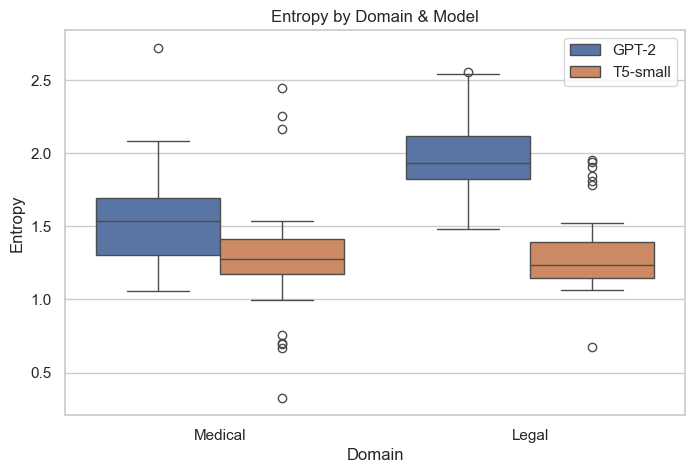

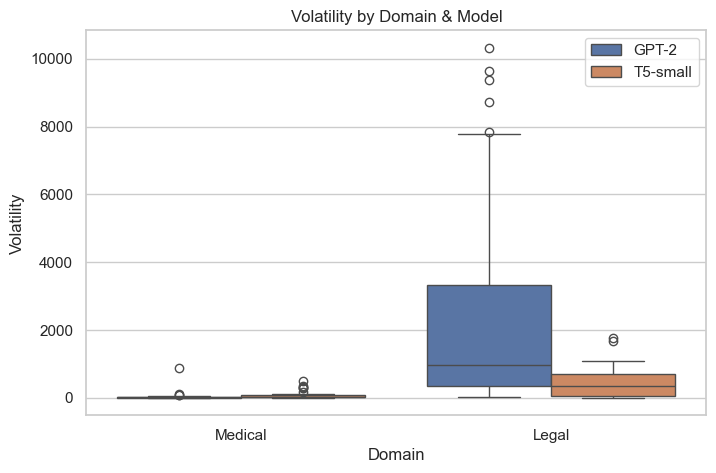

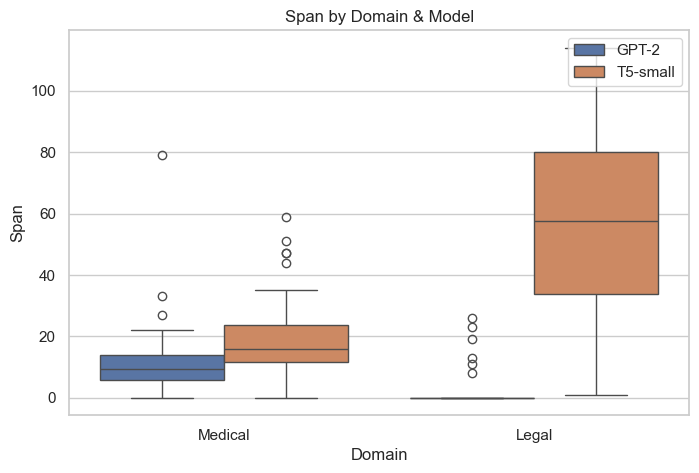

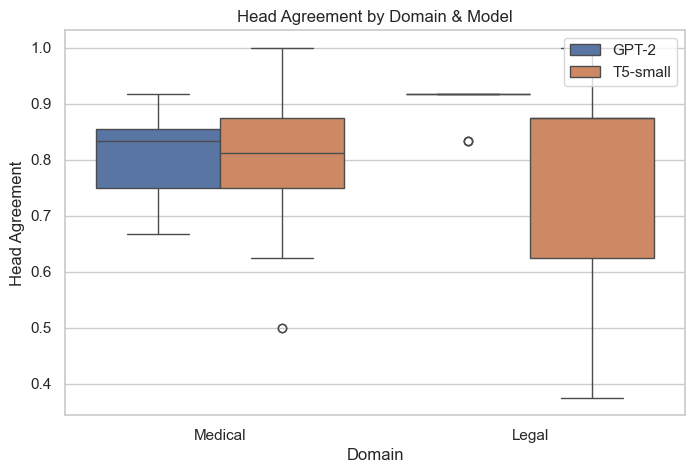

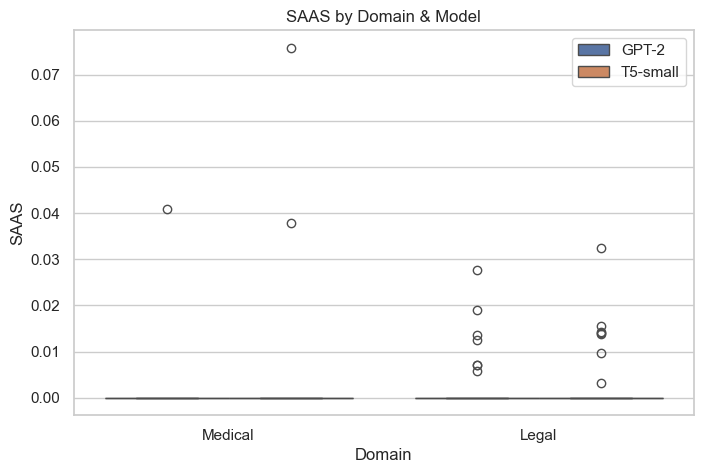

In [58]:
# ─── Section 7: Visualizations ────────────────────────────────────────

for metric in ["Entropy", "Volatility", "Span", "Head Agreement", "SAAS"]:
    plt.figure(figsize=(8,5))
    sns.boxplot(data=metrics_df, x="Domain", y=metric, hue="Model")
    plt.title(f"{metric} by Domain & Model")
    plt.legend(loc="upper right")
    plt.show()


In [60]:
# ───  Heatmap Utilities ───────────────────────────────────

import matplotlib.pyplot as plt
import seaborn as sns

def plot_self_attention_heatmap(tokens, attn_tensor, title):
    """
    tokens: List[str]
    attn_tensor: np.ndarray, shape (seq_len, seq_len)
                 e.g. layer_attn.mean(axis=0) averaged over heads
    """
    plt.figure(figsize=(8,6))
    sns.heatmap(attn_tensor, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_cross_attention_heatmap(src_tokens, tgt_tokens, cross_attn, title):
    """
    cross_attn: np.ndarray, shape (tgt_seq, src_seq)
    """
    plt.figure(figsize=(10,4))
    sns.heatmap(cross_attn, xticklabels=src_tokens, yticklabels=tgt_tokens,
                cmap="magma", cbar_kws={"shrink":0.6})
    plt.title(title)
    plt.xlabel("Source Tokens")
    plt.ylabel("Target Tokens")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


/usr/local/Caskroom/miniconda/base/envs/IE7500/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Arial.
  fig.canvas.draw()
/usr/local/Caskroom/miniconda/base/envs/IE7500/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


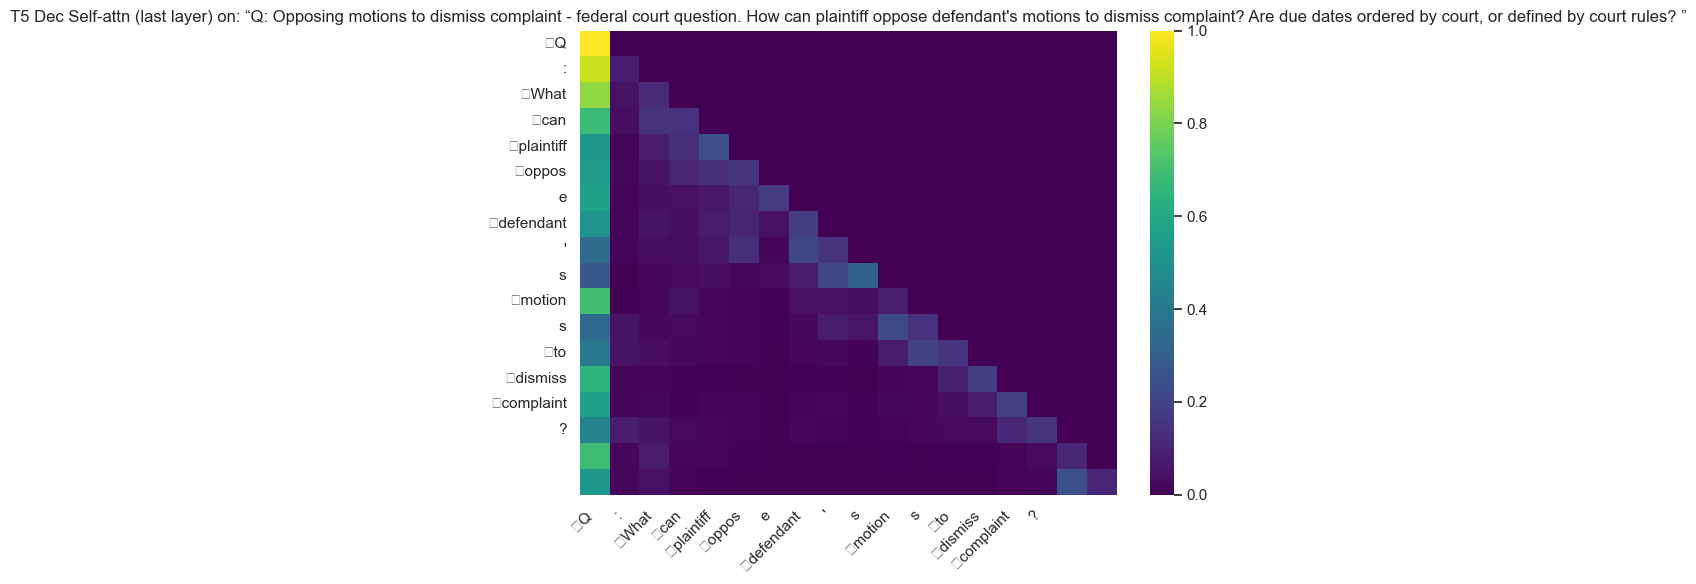

/usr/local/Caskroom/miniconda/base/envs/IE7500/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Arial.
  fig.canvas.draw()
/usr/local/Caskroom/miniconda/base/envs/IE7500/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


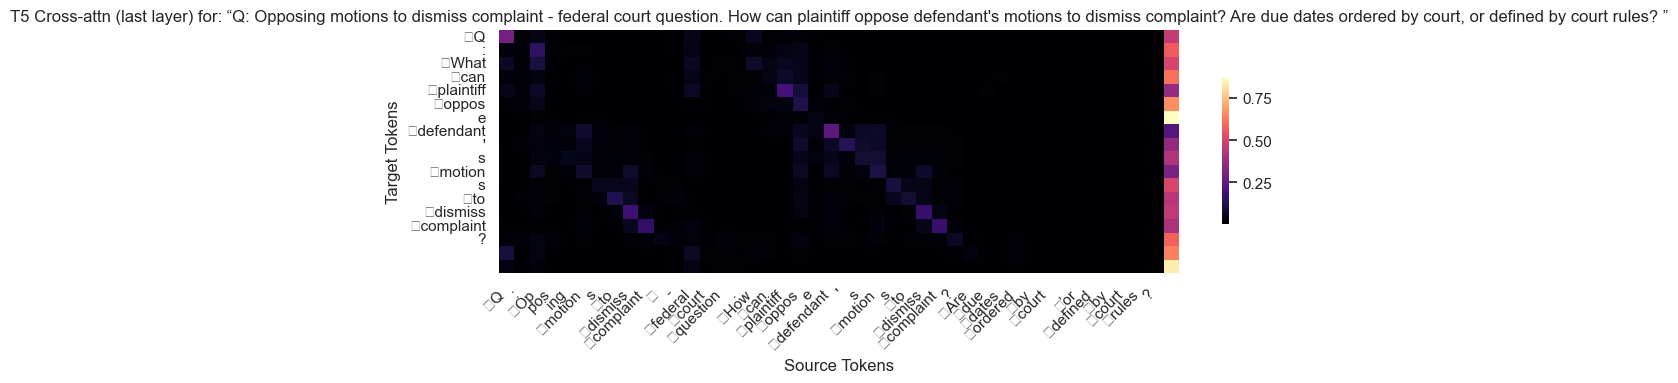

In [61]:
# ─── Plot Example Heatmaps ────────────────────────────────

# Choose a representative pair (e.g. highest SAAS in Legal)
example_idx = metrics_df[
    (metrics_df.Model=="T5-small") & (metrics_df.Domain=="Legal")
].sort_values("SAAS", ascending=False).Question.index[0]


#q = qa_pairs.loc[example_idx, "Question"]
q =metrics_df.loc[example_idx, "Question"]
# Run T5 to get attentions (using your fixed run_t5 function)
_, enc_attn, dec_attn, cross_attn = run_t5(q)

# Tokens
src_tokens = t5_tokenizer.tokenize(q)
# Generate answer to get tgt_tokens
ans, *_ = run_t5(q)
tgt_tokens = t5_tokenizer.tokenize(ans)

# Aggregate last‐layer, head‐avg tensors
last_self = dec_attn[-1][0].mean(dim=0).cpu().numpy()   # (tgt_seq, tgt_seq)
last_cross = cross_attn[-1][0].mean(dim=0).cpu().numpy()  # (tgt_seq, src_seq)

# Plot
plot_self_attention_heatmap(tgt_tokens, last_self, 
    f"T5 Dec Self-attn (last layer) on: “{q}”")
plot_cross_attention_heatmap(src_tokens, tgt_tokens, last_cross, 
    f"T5 Cross-attn (last layer) for: “{q}”")


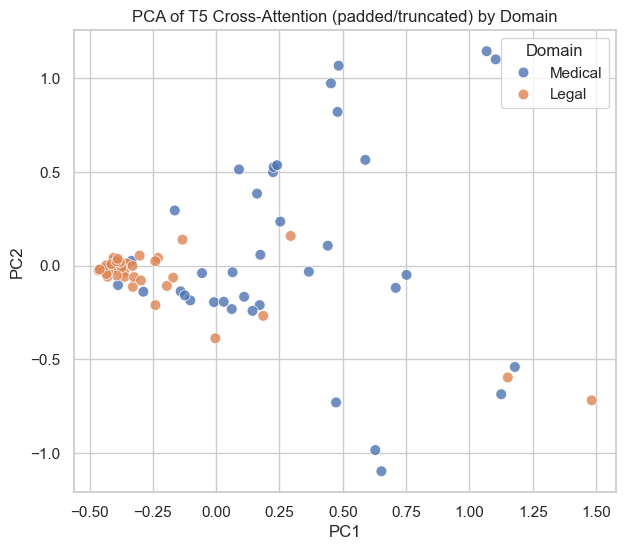

In [ ]:
# ───  PCA/t-SNE on Cross-Attention Vectors  ────────

from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE  # 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Determine the maximum source‐token length
src_lens = [len(t5_tokenizer.tokenize(q)) for q in qa_pairs.Question]
max_len  = max(src_lens)

flat_vecs = []
labels    = []

for q, domain in zip(qa_pairs.Question, qa_pairs.Domain):
    # get per‐layer cross‐attention averaged over heads → (tgt_seq, src_seq)
    _, _, _, cross_a = run_t5(q)
    cross_avg = np.mean(
        [layer[0].mean(dim=0).cpu().numpy() for layer in cross_a],
        axis=0
    ).flatten()  # shape (src_seq,)

    # 2) Pad or truncate to max_len
    if len(cross_avg) < max_len:
        padded = np.concatenate([
            cross_avg,
            np.zeros(max_len - len(cross_avg))
        ])
    else:
        padded = cross_avg[:max_len]

    flat_vecs.append(padded)
    labels.append(domain)

# 3) Stack into array of shape (num_samples, max_len)
flat_arr = np.stack(flat_vecs)

# 4) PCA down to 2 dimensions
proj = PCA(n_components=2).fit_transform(flat_arr)

# 5) Build DataFrame & plot
df_proj = pd.DataFrame(proj, columns=["PC1","PC2"])
df_proj["Domain"] = labels

plt.figure(figsize=(7,6))
sns.scatterplot(
    data=df_proj,
    x="PC1", y="PC2",
    hue="Domain",
    s=60, alpha=0.8
)
plt.title("PCA of T5 Cross-Attention (padded/truncated) by Domain")
plt.show()


In [63]:
# ─── Statistical Evaluation ──────────────────────────────

from scipy.stats import mannwhitneyu

tests = []
for metric in ["Entropy","Volatility","Span","Head Agreement","SAAS"]:
    med_vals = metrics_df[(metrics_df.Domain=="Medical") & (metrics_df.Model=="T5-small")][metric]
    leg_vals = metrics_df[(metrics_df.Domain=="Legal")   & (metrics_df.Model=="T5-small")][metric]
    stat, p = mannwhitneyu(med_vals, leg_vals, alternative="two-sided")
    tests.append((metric, stat, p))

pd.DataFrame(tests, columns=["Metric","Mann–Whitney U","p-value"])


,Metric,Mann–Whitney U,p-value
0,Entropy,843.0,6.825716e-01
1,Volatility,398.0,1.109763e-04
2,Span,205.5,1.073946e-08
3,Head Agreement,862.0,5.422654e-01
4,SAAS,707.0,1.047179e-01
